# Handwritten digits recognition

## Import packages

In [152]:
import numpy as np
from matplotlib import pyplot as plt
import math

## Define and initialization

In [153]:
def tanh(x):
    return np.tanh(x)


def softmax(x):
    exp = np.exp(x - x.max())
    return exp / exp.sum()


train_num = 50000
valid_num = 10000
test_num = 10000
dimensions = [28 * 28, 10]
activation = [tanh, softmax]
w_range = math.sqrt(6 / (dimensions[0] + dimensions[1]))
dists = [
    {'b': [0, 0]},
    {'b': [0, 0], 'w': [-w_range, w_range]}
]


def init_paras_b(layer: int):
    dist = dists[layer]['b']
    return np.random.rand(dimensions[layer]) * (dist[1] - dist[0]) + dist[0]


def init_paras_w(layer: int):
    dist = dists[layer]['w']
    return np.random.rand(dimensions[layer - 1], dimensions[layer]) * (dist[1] - dist[0]) + dist[0]


def init_paras():
    parameters = []
    for layer in range(len(dists)):
        layer_paras = {}
        for key_name in dists[layer].keys():
            if key_name == 'b':
                layer_paras['b'] = init_paras_b(layer)
                continue
            if key_name == 'w':
                layer_paras['w'] = init_paras_w(layer)
                continue
        parameters.append(layer_paras)
    return parameters


def predict(img, paras):
    layer0_in = img + paras[0]['b']
    layer0_out = activation[0](layer0_in)
    layer1_in = np.dot(layer0_out, paras[1]['w']) + paras[1]['b']
    layer1_out = activation[1](layer1_in)
    return layer1_out

## Load data

In [154]:
with open('./dataset/train-images.idx3-ubyte', 'rb') as f:
    f.read(16)
    temp_img = np.fromfile(f, dtype=np.uint8).reshape(-1, 28 * 28)
    train_img = temp_img[:train_num]
    valid_img = temp_img[train_num:]

with open('./dataset/train-labels.idx1-ubyte', 'rb') as f:
    f.read(8)
    temp_lab = np.fromfile(f, dtype=np.uint8)
    train_lab = temp_lab[:train_num]
    valid_lab = temp_lab[train_num:]

with open('./dataset/t10k-images.idx3-ubyte', 'rb') as f:
    f.read(16)
    test_img = np.fromfile(f, dtype=np.uint8).reshape(-1, 28 * 28)

with open('./dataset/t10k-labels.idx1-ubyte', 'rb') as f:
    f.read(8)
    test_lab = np.fromfile(f, dtype=np.uint8)

train_data = [train_img, train_lab]
test_data = [test_img, test_lab]
valid_data = [valid_img, valid_lab]


def show_data(data_type, index):
    plt.imshow(data_type[0][index].reshape(28, 28))
    print(data_type[1][index])

## Train

In [155]:
def d_softmax(data):
    sm = softmax(data)
    return np.diag(sm) - np.outer(sm, sm)


def d_tanh(data):
    # return np.diag(1/(np.cosh(data))**2)
    return 1 / (np.cosh(data)) ** 2


differential = {tanh: d_tanh, softmax: d_softmax}

onehot = np.identity(dimensions[-1])


def sqr_loss(img, lab, paras):
    y_pred = predict(img, paras)
    y = onehot[lab]
    diff = y - y_pred
    return np.dot(diff, diff)


def grad_paras(img, lab, paras):
    layer0_in = img + paras[0]['b']
    layer0_out = activation[0](layer0_in)
    layer1_in = np.dot(layer0_out, paras[1]['w']) + paras[1]['b']
    layer1_out = activation[1](layer1_in)

    diff = onehot[lab] - layer1_out
    act1 = np.dot(differential[activation[1]](layer1_in), diff)
    grad_b1 = -2 * act1
    grad_w1 = -2 * np.outer(layer0_out, act1)
    grad_b0 = -2 * differential[activation[0]](layer0_in) * np.dot(paras[1]['w'], act1)
    return {'w1': grad_w1, 'b1': grad_b1, 'b0': grad_b0}


def valid_accu(paras):
    correct = [predict(valid_img[img_i], paras).argmax() == valid_lab[img_i] for img_i in range(valid_num)]
    print(correct.count(True) / len(correct))

In [156]:
batch_size = 100


def train_batch(current_batch, paras):
    grad_accu = grad_paras(train_img[current_batch * batch_size + 0], train_lab[current_batch * batch_size + 0], paras)
    for img_i in range(1, batch_size):
        grad_tmp = grad_paras(train_img[current_batch * batch_size + img_i],
                              train_lab[current_batch * batch_size + img_i], paras)
        for key in grad_accu.keys():
            grad_accu[key] += grad_tmp[key]
    for key in grad_accu.keys():
        grad_accu[key] /= batch_size
    return grad_accu

## Gradient Descent

In [157]:
import copy


def combine_parameters(paras, grad, learn_rate):
    parameter_tmp = copy.deepcopy(paras)
    parameter_tmp[0]['b'] -= learn_rate * grad['b0']
    parameter_tmp[1]['b'] -= learn_rate * grad['b1']
    parameter_tmp[1]['w'] -= learn_rate * grad['w1']
    return parameter_tmp

In [158]:
parameters = init_paras()
current_epoch = 0
valid_accu(parameters)

0.1236


In [159]:
from tqdm import tqdm_notebook

learn_rate = 10 ** -0.6
epoch_num = 10
for epoch in tqdm_notebook(range(epoch_num)):
    for i in range(train_num // batch_size):
        grad_tmp = train_batch(i, parameters)
        parameters = combine_parameters(parameters, grad_tmp, learn_rate)
    current_epoch += 1

C:\Users\26905\AppData\Local\Temp\ipykernel_3484\3917854831.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for epoch in tqdm_notebook(range(epoch_num)):


  0%|          | 0/10 [00:00<?, ?it/s]

## Predict

5
0.9222


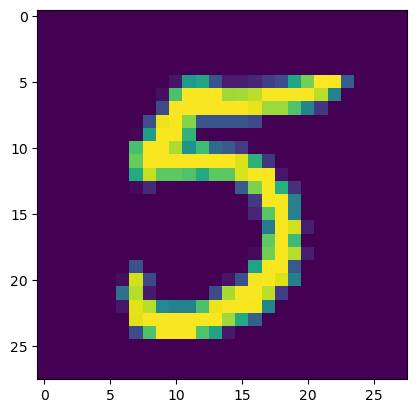

In [194]:
index = np.random.randint(test_num)
print(predict(test_img[index], parameters).argmax())
plt.imshow(test_img[index].reshape(28, 28))
valid_accu(parameters)